In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
from lsst.sims.maf.utils import m52snr
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.plots as plots

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from lsst.utils import getPackageDir
from mafContrib import TdePopMetric, generateTdePopSlicer, Tde_lc
import healpy as hp
import os

/Users/yoachim/git_repos/sims_maf_contrib/mafContrib/transientAsciiSEDMetric.py:19: UserWarning: sncosmo not installed
  warnings.warn('sncosmo not installed')
/Users/yoachim/git_repos/sims_maf_contrib/mafContrib/LSSObsStrategy/artificialStructureCalculation.py:40: UserWarning: sympy not installed
  warnings.warn('sympy not installed')


In [2]:
# Generate the slicer which puts 10,000 events at random spots on the sphere
slicer = generateTdePopSlicer(seed=42)

In [3]:
runName = 'baseline_v1.5_10yrs' 
opsdb = db.OpsimDatabase(runName+'.db')
outDir = 'temp'
resultsDb = db.ResultsDb(outDir=outDir)

metric = TdePopMetric()
sql = ''
# Don't want to try and plot N individual points, 
plotDict = {'nside': 64, 'reduceFunc': np.sum, 'colorMin': 0}
plotFuncs = [plots.HealpixSkyMap()]
summaryMetrics=[metrics.MeanMetric(maskVal=0)]
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName,
                                    plotDict=plotDict, plotFuncs=plotFuncs,
                                    summaryMetrics=summaryMetrics)

Querying database SummaryAllProps with no constraint for columns ['night', 'fiveSigmaDepth', 'observationStartMJD', 'fieldDec', 'filter', 'fieldRA'].
Found 2224095 visits
Running:  ['baseline_v1_5_10yrs_TDEsPopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:518: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/env

Plotting complete.


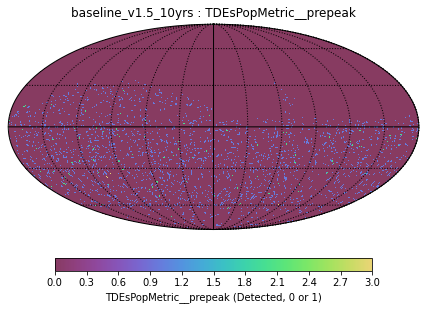

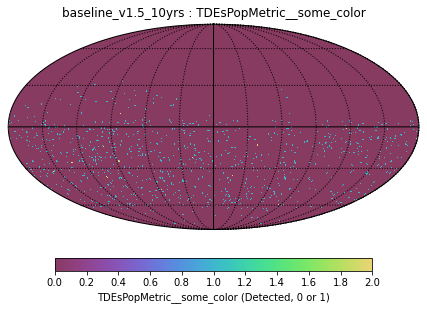

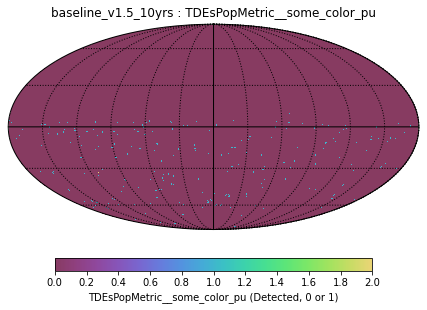

In [4]:
bd = metricBundles.makeBundlesDictFromList([bundle])
bgroup = metricBundles.MetricBundleGroup(bd, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [5]:
# Let's see how we do.
for key in bd:
    print(key, bd[key].summaryValues)

baseline_v1_5_10yrs_TDEsPopMetric_USER {}
TDEsPopMetric__prepeak {'Mean': 0.2553}
TDEsPopMetric__some_color {'Mean': 0.0961}
TDEsPopMetric__some_color_pu {'Mean': 0.0214}


/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:9

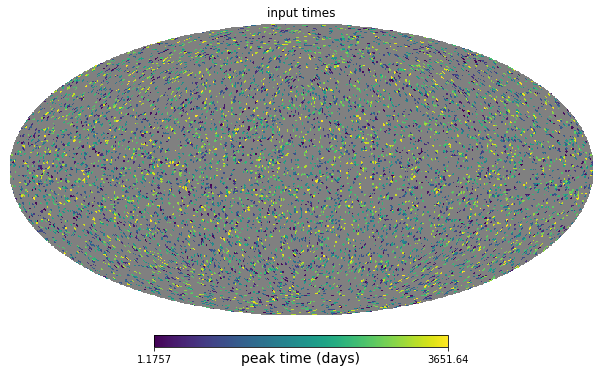

In [6]:
# Check that the positions and times look random
hp.mollview(_healbin(slicer.slicePoints['ra'], slicer.slicePoints['dec'], 
           slicer.slicePoints['peak_time'], 64, reduceFunc=np.mean), unit='peak time (days)',
           title='input times')

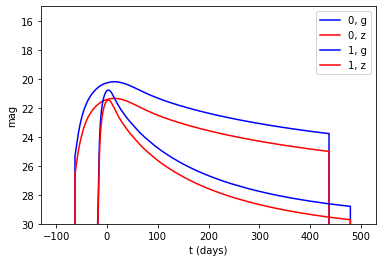

In [7]:
# let's plot up a few of the lightcurves
ivals=[0,1]

for i in ivals:
    t = np.arange(-100, 500)
    lc = metric.lightcurves.interp(t, 'g', lc_indx=slicer.slicePoints['file_indx'][i])
    plt.plot(t, lc, color='blue', label='%i, g' % i)
    lc = metric.lightcurves.interp(t, 'z', lc_indx=slicer.slicePoints['file_indx'][i])
    plt.plot(t, lc, color='red', label='%i, z' % i)
plt.ylim([30,15])
plt.xlabel('t (days)')
plt.ylabel('mag')
plt.legend()

In [8]:
# Let's see if there's a preference for which light curve was detected
indxes = np.unique(slicer.slicePoints['file_indx'])
for indx in indxes:
    in_indx = np.where(slicer.slicePoints['file_indx'] == indx)[0]
    n_total = in_indx.size
    detected = bd['TDEsPopMetric__prepeak'].metricValues[in_indx].sum()
    print('file indx %i and %f fraction recovered' % (indx, detected/n_total))

file indx 0 and 0.367911 fraction recovered
file indx 1 and 0.231037 fraction recovered
file indx 2 and 0.128134 fraction recovered
file indx 3 and 0.213246 fraction recovered
file indx 4 and 0.343284 fraction recovered
file indx 5 and 0.129907 fraction recovered
file indx 6 and 0.365922 fraction recovered
